<a href="https://colab.research.google.com/github/OleksandrZadvornyi/weather-forecasting/blob/main/test_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q transformers
!pip install -q datasets
!pip install -q evaluate
!pip install -q accelerate
!pip install -q gluonts ujson
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12

In [3]:
import os
from datasets import load_from_disk
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from evaluate import load
from gluonts.time_feature import get_seasonality, time_features_from_frequency_str
from transformers import TimeSeriesTransformerForPrediction, TimeSeriesTransformerConfig
from gluonts.dataset.common import ListDataset
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    InstanceSplitter,
    RemoveFields,
    TestSplitSampler,
    VstackFeatures,
    RenameFields,
)
from gluonts.dataset.field_names import FieldName

In [4]:
# Load model and configuration
model_dir = "/content/drive/MyDrive/weather_forecasting_project/weather_model"
model_path = os.path.join(model_dir, "time_series_model.pth")
config_path = os.path.join(model_dir, "config")

# Load configuration
config = TimeSeriesTransformerConfig.from_pretrained(config_path)

# Load metadata
metadata = {}
with open(os.path.join(config_path, "metadata.txt"), "r") as f:
    for line in f:
        key, value = line.strip().split("=")
        metadata[key] = value

freq = metadata["freq"]
prediction_length = int(metadata["prediction_length"])
target_column = metadata.get("target_column", "TMAX")

In [6]:
# Initialize model
model = TimeSeriesTransformerForPrediction(config)
model.load_state_dict(torch.load(model_path))
model.eval()

# Load test dataset
data_dir = "/content/drive/MyDrive/weather_forecasting_project/prepared_datasets"
dataset = load_from_disk(f"{data_dir}/dataset")
test_dataset = dataset["test"]

# Convert test dataset to GluonTS ListDataset format
def convert_to_gluonts_dataset(hf_dataset, freq):
    data = []
    for item in hf_dataset:
        data.append({
            FieldName.START: pd.Period(item["start"], freq=freq),
            FieldName.TARGET: item["target"],
            FieldName.FEAT_STATIC_CAT: [item["feat_static_cat"][0]],
            FieldName.FEAT_STATIC_REAL: item["feat_static_real"],
            FieldName.ITEM_ID: item["item_id"]
        })
    return ListDataset(data, freq=freq)

gluonts_test_dataset = convert_to_gluonts_dataset(test_dataset, freq)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

TimeSeriesTransformerForPrediction(
  (model): TimeSeriesTransformerModel(
    (scaler): TimeSeriesMeanScaler()
    (embedder): TimeSeriesFeatureEmbedder(
      (embedders): ModuleList(
        (0): Embedding(19, 2)
      )
    )
    (encoder): TimeSeriesTransformerEncoder(
      (value_embedding): TimeSeriesValueEmbedding(
        (value_projection): Linear(in_features=41, out_features=64, bias=False)
      )
      (embed_positions): TimeSeriesSinusoidalPositionalEmbedding(540, 64)
      (layers): ModuleList(
        (0-3): 4 x TimeSeriesTransformerEncoderLayer(
          (self_attn): TimeSeriesTransformerAttention(
            (k_proj): Linear(in_features=64, out_features=64, bias=True)
            (v_proj): Linear(in_features=64, out_features=64, bias=True)
            (q_proj): Linear(in_features=64, out_features=64, bias=True)
            (out_proj): Linear(in_features=64, out_features=64, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((64,), eps=1e-05, element

In [8]:
# Create test transformation
def create_test_transformation(freq: str, config: TimeSeriesTransformerConfig):
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    return Chain(
        [RemoveFields(field_names=remove_field_names)]
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                expected_ndim=1,
            ),
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE],
            ),
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

# Create test instance splitter
def create_test_instance_splitter(config):
    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=TestSplitSampler(),
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

# Create test dataloader
def create_test_dataloader(dataset, config, freq, batch_size=64):
    transformation = create_test_transformation(freq, config)
    transformed_data = transformation.apply(dataset, is_train=False)

    instance_splitter = create_test_instance_splitter(config)
    testing_instances = instance_splitter.apply(transformed_data, is_train=False)

    from gluonts.dataset.loader import as_stacked_batches
    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=[
            "past_time_features",
            "past_values",
            "past_observed_mask",
            "future_time_features",
            "static_categorical_features",
            "static_real_features",
        ],
    )

In [9]:
# Generate forecasts
forecasts = []
test_dataloader = create_test_dataloader(gluonts_test_dataset, config, freq)

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device),
        static_real_features=batch["static_real_features"].to(device),
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts.append(outputs.sequences.cpu().numpy())

forecasts = np.vstack(forecasts)
print(f"Generated forecasts shape: {forecasts.shape}")

Generated forecasts shape: (19, 100, 180)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


MASE: 24.36158501526972
sMAPE: 1.196179935434003


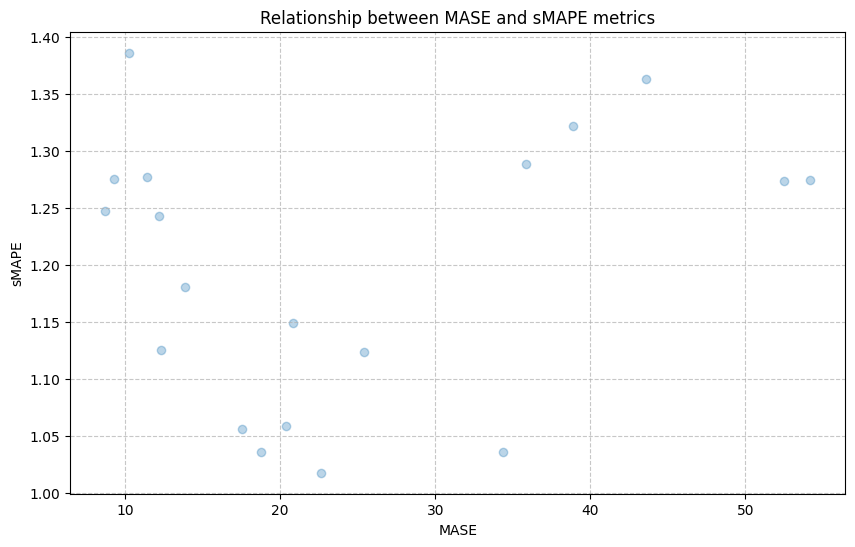

In [10]:
# Calculate evaluation metrics
mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

forecast_median = np.median(forecasts, axis=1)

mase_metrics = []
smape_metrics = []

for item_id, ts in enumerate(test_dataset):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]

    mase = mase_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
        training=np.array(training_data),
        periodicity=get_seasonality(freq)
    )
    mase_metrics.append(mase["mase"])

    smape = smape_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth)
    )
    smape_metrics.append(smape["smape"])

print(f"MASE: {np.mean(mase_metrics)}")
print(f"sMAPE: {np.mean(smape_metrics)}")

# Add scatter plot comparing MASE and sMAPE metrics (like in the example script)
plt.figure(figsize=(10, 6))
plt.scatter(mase_metrics, smape_metrics, alpha=0.3)
plt.xlabel("MASE")
plt.ylabel("sMAPE")
plt.title("Relationship between MASE and sMAPE metrics")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

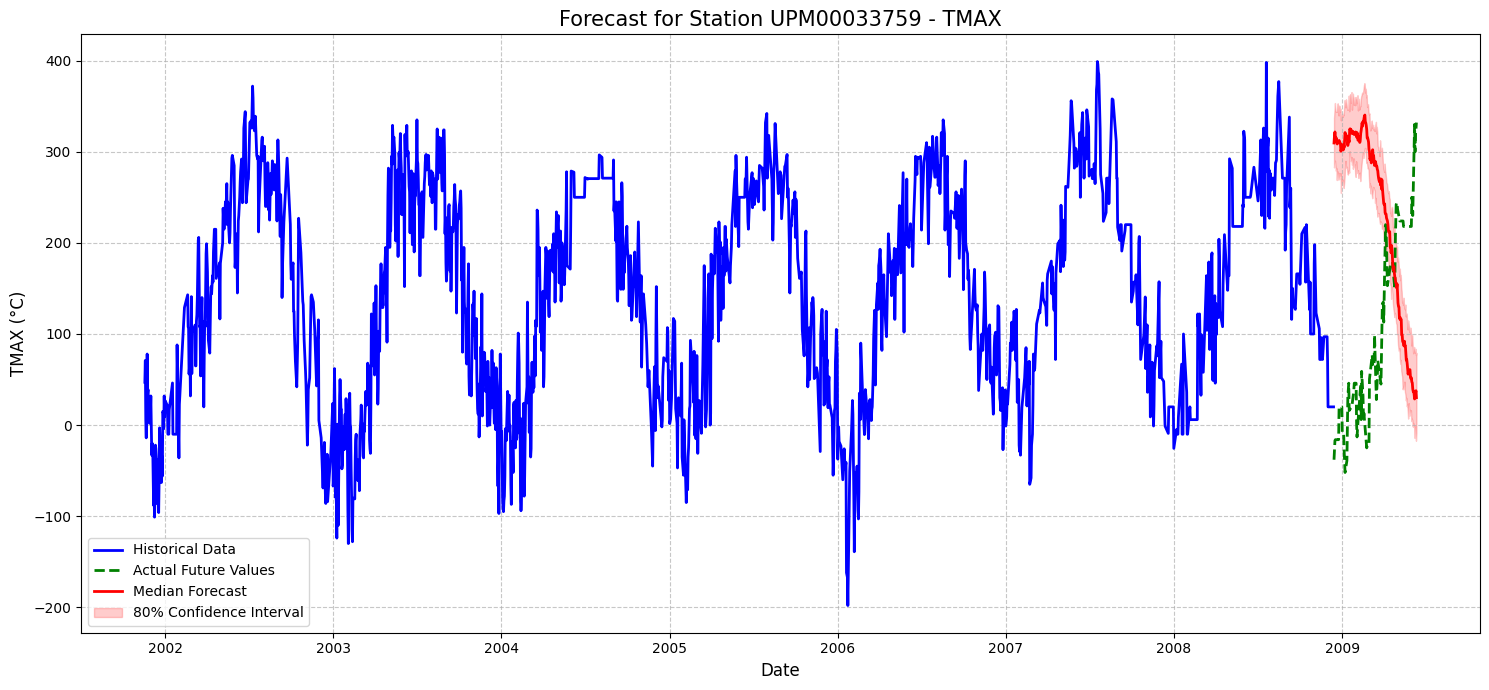

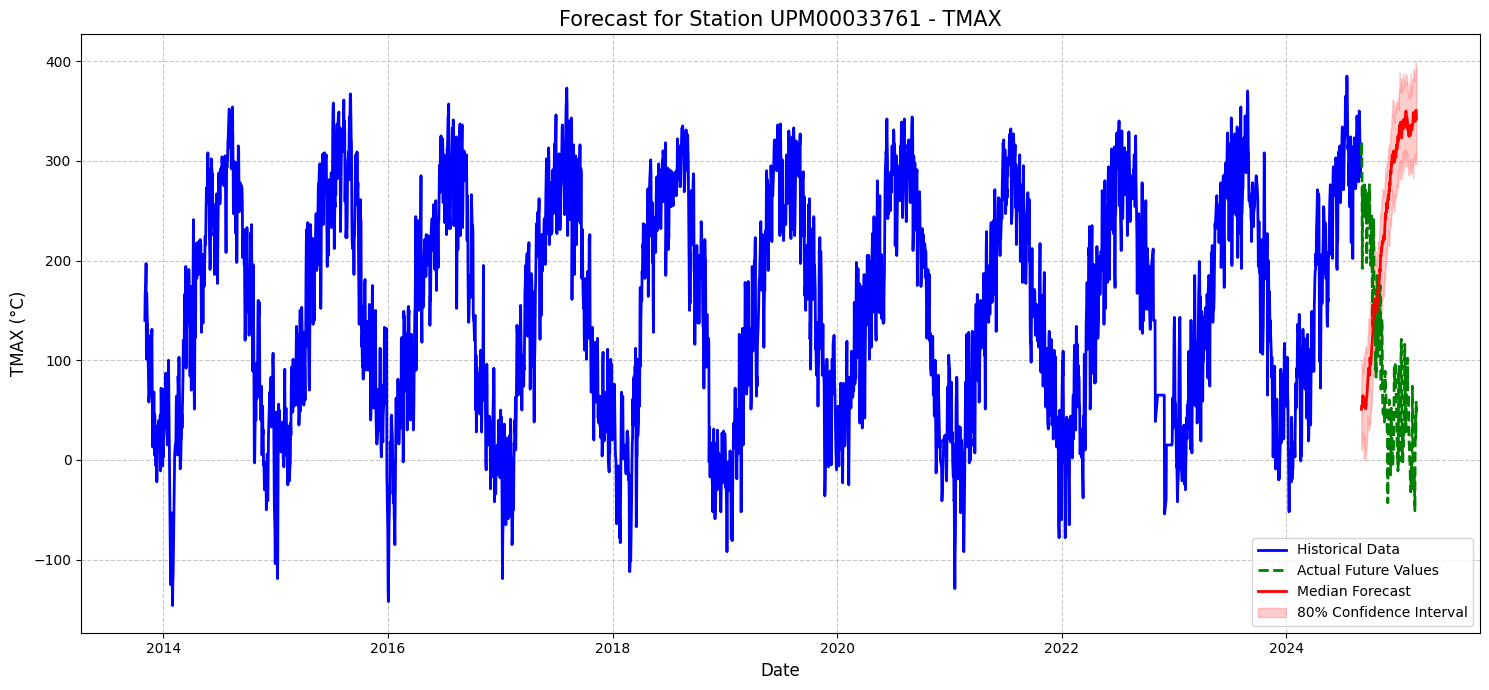

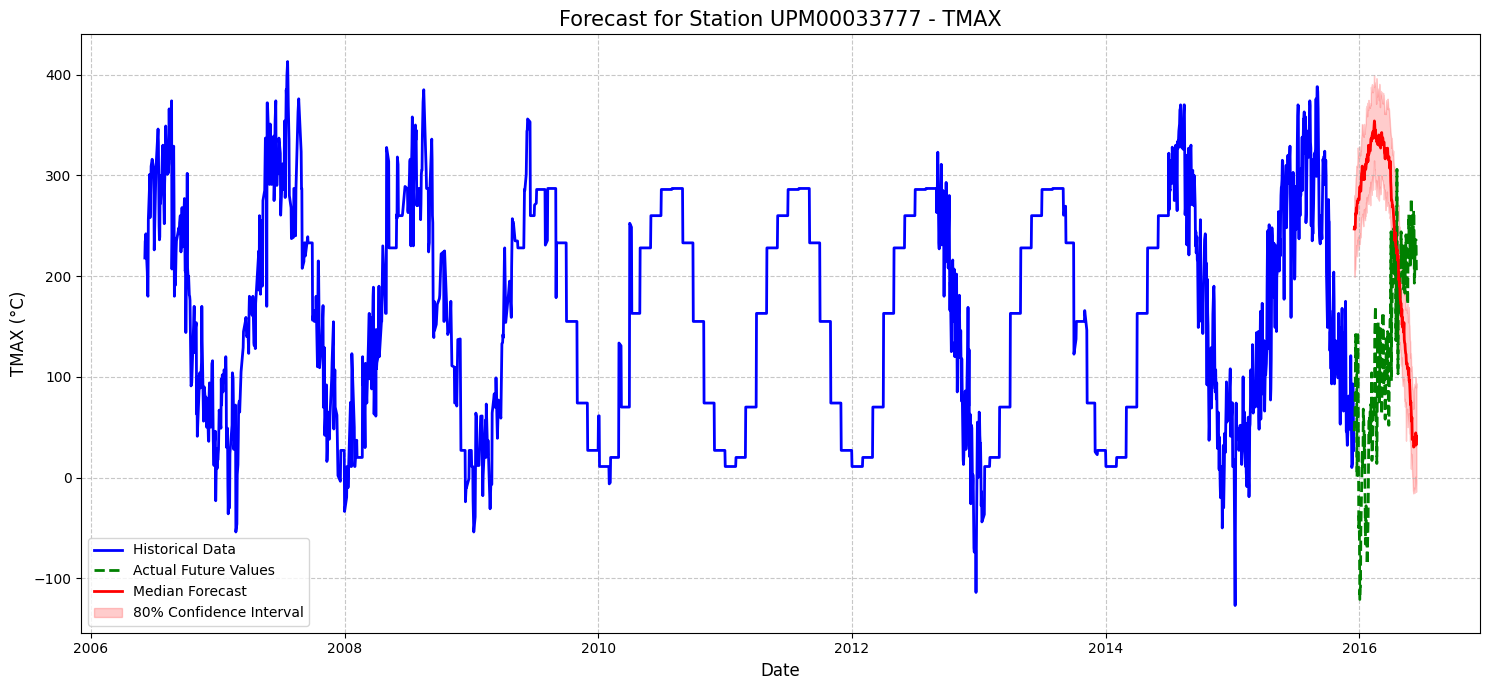

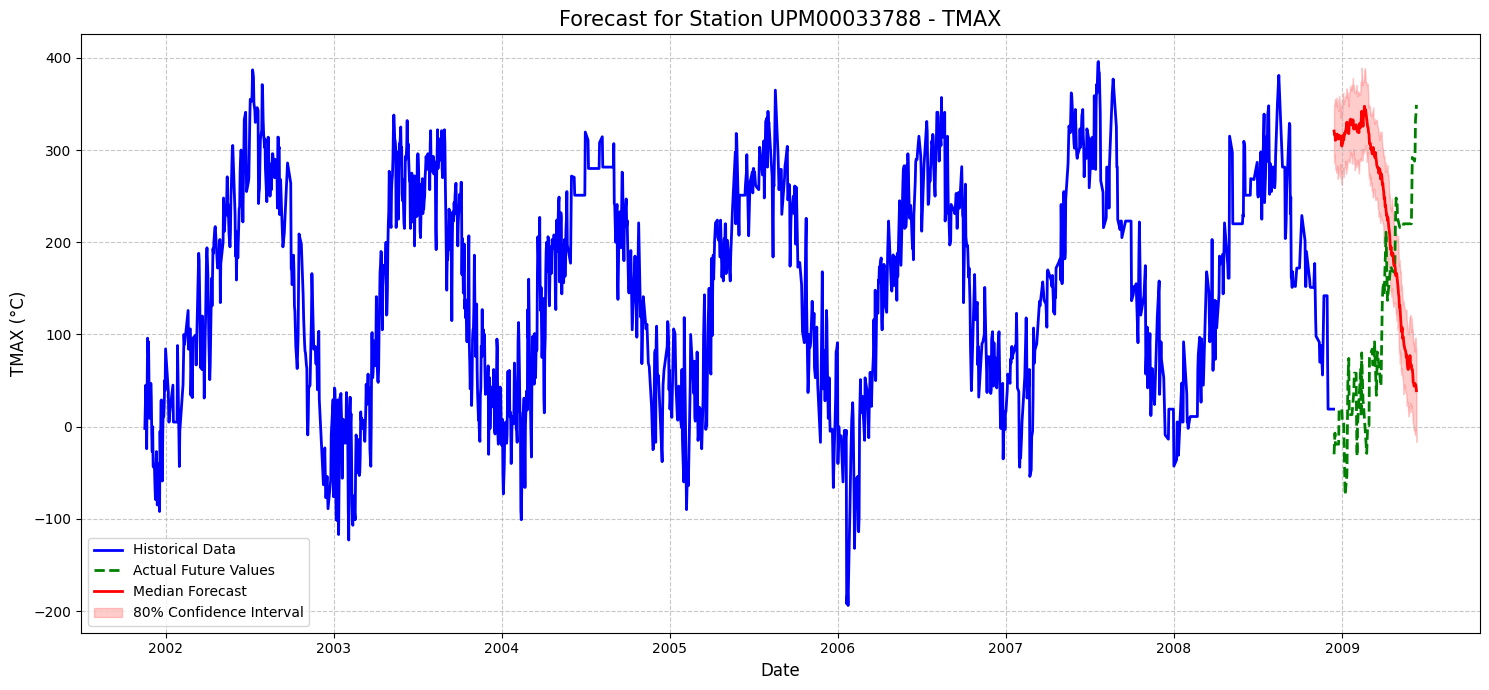

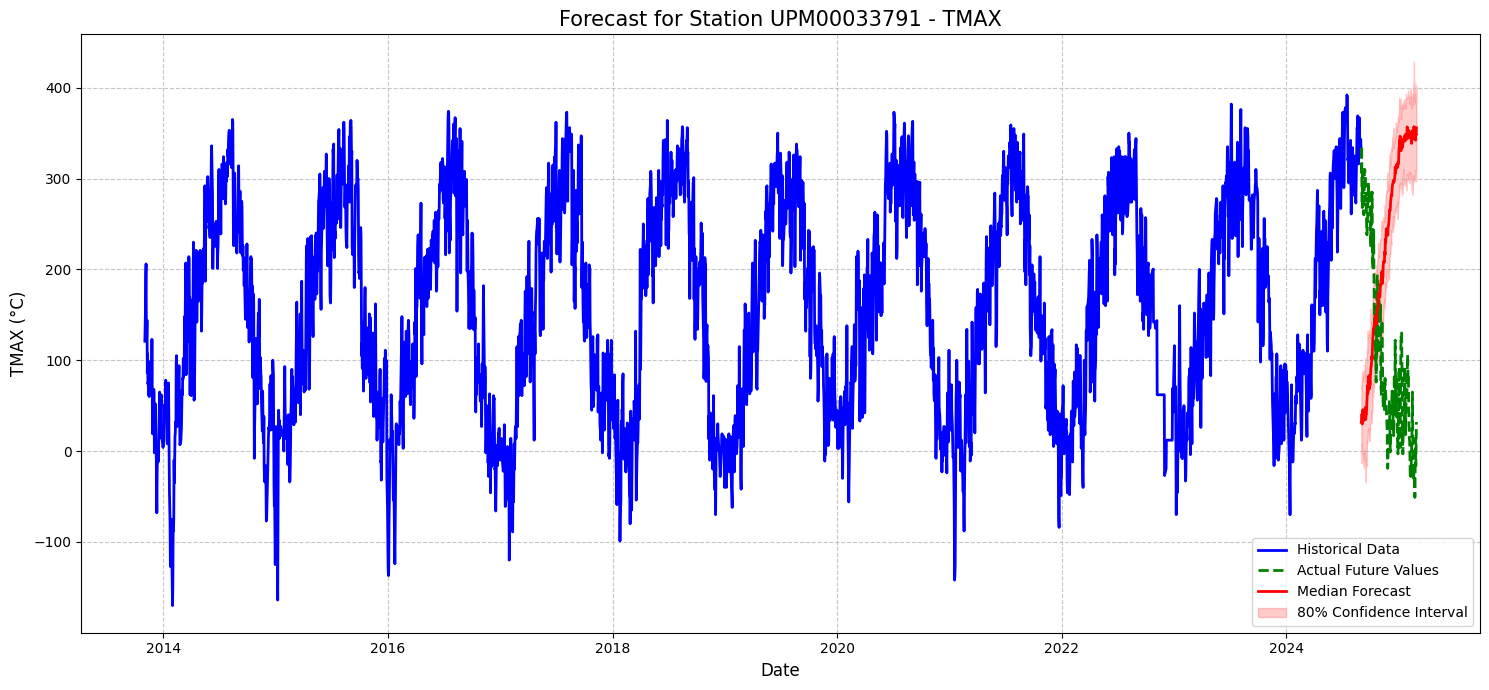

In [11]:
# Plot some sample forecasts
def plot_forecast(ts_index, prediction_length=30):
    fig, ax = plt.subplots(figsize=(15, 7))

    # Get the test example
    ts = test_dataset[ts_index]

    # Create date range
    dates = pd.date_range(
        start=pd.Period(ts["start"], freq=freq).start_time,
        periods=len(ts["target"]),
        freq=freq,
    )

    # Plot historical data
    ax.plot(
        dates[:-prediction_length],
        ts["target"][:-prediction_length],
        label="Historical Data",
        color="blue",
        linewidth=2
    )

    # Plot actual values in forecast period
    ax.plot(
        dates[-prediction_length:],
        ts["target"][-prediction_length:],
        label="Actual Future Values",
        color="green",
        linestyle="--",
        linewidth=2
    )

    # Plot median forecast
    ax.plot(
        dates[-prediction_length:],
        forecast_median[ts_index],
        label="Median Forecast",
        color="red",
        linewidth=2
    )

    # Plot forecast uncertainty with wider confidence interval
    ax.fill_between(
        dates[-prediction_length:],
        np.percentile(forecasts[ts_index], 10, axis=0),
        np.percentile(forecasts[ts_index], 90, axis=0),
        color="red",
        alpha=0.2,
        label="80% Confidence Interval"
    )

    ax.set_title(f"Forecast for Station {ts['item_id']} - {target_column}", fontsize=15)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel(f"{target_column} (°C)", fontsize=12)
    ax.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot with longer prediction length
for i in range(5):
    plot_forecast(i, prediction_length=180)